### Import Libraries

In [2]:
from wrapper_functions import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.11.0. Expected: 2.7.0
TensorFlow Probability version: 0.19.0. Expected: 0.15.0


### Create the fake data



In [3]:
#training2010 = pd.read_csv('../data/merged_wp_census_data_280922.csv')
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
models = ['acs', 'pep', 'worldpop']

In [4]:
def simulate_data2(data, adjacency):
    data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
    data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
    data['worldpop'] = np.random.normal(120.0, 10.0, data.shape[0])
    
    tau2 = 1
    rho = 0.3
    print('fixing tau2 and rho')

    data = data
    nchain = 1

    data['census'] = np.random.poisson(data['worldpop'].to_numpy())
    
    return data

In [5]:
def simulate_data(data, adjacency):
    data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
    data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
    data['worldpop'] = np.random.normal(120.0, 10.0, data.shape[0])
    
    tau2 = 1
    rho = 0.3
    print('fixing tau2 and rho')

    data = data
    nchain = 1

    Q = (1/tau2)*(np.diag(adjacency.sum(axis=1)) - rho*adjacency)
    Q = tf.constant(Q, dtype = tf.float32)
    phi_true = tf.constant(np.array([mv_normal_sample(precision_matrix = Q, num_models = 3) for i in range(nchain)]),
                           dtype = tf.float32)
    
    # get exponentiated values and sum across models
    exp_phi = tf.math.exp(phi_true)
    exp_phi_rows = tf.reduce_sum(exp_phi, 2)

    # get model weights and calculate mean estimate
    u_true = exp_phi/exp_phi_rows[...,None]

    tmp = data[models].values*u_true
    n = tf.reduce_sum(tmp, axis = 2)

    data['census'] = np.random.poisson(n)[0]
    
    return phi_true, u_true, data


In [6]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')
phi_true, u_true, data = simulate_data(data_NY, adj_NY)
#data = simulate_data2(data_NY, adj_NY)
data_sub = data_NY
adj_sub = adj_NY

fixing tau2 and rho


C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_17336\3856900505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_17336\3856900505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
C:\Users\Admin-Dell\AppData\Local\Temp\ipykernel_17336\3856900505.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [7]:
# data_TX, adj_TX = subset_data_by_state(training2010, county_adj, ', Texas', 'TX')
# Had to put in the comma because there are some cities in other states with "Texas" in the name
# phi_true, u_true, data = simulate_data(data_TX, adj_TX)

# Default Configs

In [8]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

#### Running with HMC

In [9]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 2_500, num_steps = 5_000, nchain = 5, 
                        kernel_type = 'nuts', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 5000,
 'burnin': 2500,
 'nchain': 5,
 'seed': 0,
 'kernel_type': 'nuts',
 'step_adaptor_type': 'simple'}

In [10]:
t0 = time.perf_counter()
CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data_sub,
                                                        adjacency = adj_sub,
                                                        models = models,
                                                        debug_mode = True,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
0
-112646.40625...1000
-112699.0234375...2000
-112737.0859375...3000
-112763.6796875...4000
-112781.5859375...5000
-112792.9765625...6000
-112799.546875...7000
-112802.734375...8000
-112803.859375...9000
-112804.0078125...10000
-112803.875...11000
-112803.875...12000
-112804.2578125...13000
-112805.0703125...14000
-112806.34375...15000
-112808.0...16000
-112809.859375...17000
-112811.7734375...18000
-112813.6171875...19000
-112815.28125...Done.
kernel type is nuts
simple step size
5000
<function run_chain_CAR.<locals>.trace_fn at 0x000001974FD17DC0>


KeyboardInterrupt: 

Saving and loading Python objects with Pickle

In [ ]:
import pickle

# using local data file because these are too big for github
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_DEBUG_NY_n5000_nuts_NY_Mar152023.pickle', 'wb') as results_file:
  #pickle.dump([CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub], results_file)
  pickle.dump([CAR_samples, chain_samples, sampler_stat, mcmc_config, data_sub], results_file)

### Loading results and analyzing

In [11]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_DEBUG_NY_n50000_hmc_NY_Mar152023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    CAR_samples, chain_samples, sampler_stat, mcmc_config, data_sub = pickle.load(input_file)

In [12]:
ESS = tfp.mcmc.effective_sample_size(chain_samples, cross_chain_dims = 1).numpy()
rhat = tfp.mcmc.potential_scale_reduction(chain_samples, independent_chain_ndims=1).numpy()
print(ESS.mean())
print(rhat.mean())

244.20642
1.0251216


(array([111.,  52.,  14.,   1.,   3.,   1.,   3.,   0.,   0.,   1.]),
 array([1.0009342, 1.0218753, 1.0428164, 1.0637574, 1.0846984, 1.1056395,
        1.1265806, 1.1475216, 1.1684626, 1.1894038, 1.2103448],
       dtype=float32),
 <BarContainer object of 10 artists>)

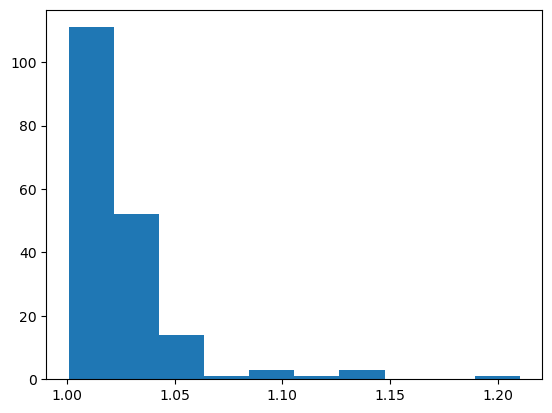

In [13]:
plt.hist(rhat.flatten())

(array([10., 11., 26., 39., 37., 35., 16.,  7.,  4.,  1.]),
 array([ 37.69791,  86.49376, 135.2896 , 184.08545, 232.8813 , 281.67715,
        330.473  , 379.26883, 428.06467, 476.86053, 525.6564 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

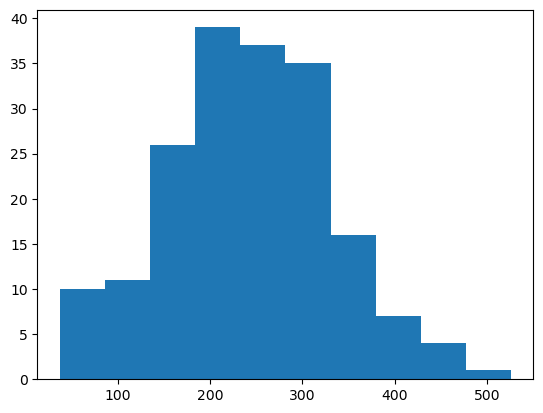

In [14]:
plt.hist(ESS.flatten())

In [15]:
data_sub.shape

(62, 8)

In [16]:
sampler_stat

(<tf.Tensor: shape=(50000,), dtype=float32, numpy=
 array([0.0199498, 0.0199498, 0.0199498, ..., 0.0199498, 0.0199498,
        0.0199498], dtype=float32)>,
 <tf.Tensor: shape=(50000,), dtype=float32, numpy=
 array([-0.5606079 , -0.8946228 , -1.3362122 , ...,  0.20715332,
        -1.9127197 , -1.3074951 ], dtype=float32)>)

In [17]:
predictions = np.empty(shape=(CAR_samples[0].shape[0], CAR_samples[0].shape[2]), dtype='object')
for i in range(CAR_samples[0].shape[2]):
    phi_vals = CAR_samples[0][:,:,i]
    
    # get exponentiated values and sum across models
    exp_phi = tf.math.exp(phi_vals)

    exp_phi_rows = tf.reduce_sum(exp_phi, 1)

    # get model weights and calculate mean estimate
    u = exp_phi/exp_phi_rows[...,None]

    tmp = data_sub[models].values*u
    predictions[:,i] = tf.reduce_sum(tmp, axis = 1)
    
y_pred = np.mean(predictions, axis = 1)

In [18]:
CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)

exp_phi_rows = tf.reduce_sum(exp_phi, 1)
    
# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]
      
#tmp = data_sub[models].values*u
#y_pred = tf.reduce_sum(tmp, axis = 1)

In [19]:
CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [24]:
from scipy.stats import pearsonr
pearsonr(data_sub['census'],data_sub['pep'])[0], pearsonr(data_sub['census'],data_sub['acs'])[0], pearsonr(data_sub['census'],data_sub['worldpop'])[0]

(0.396825088954115, 0.24653934093587462, 0.2846378257741258)

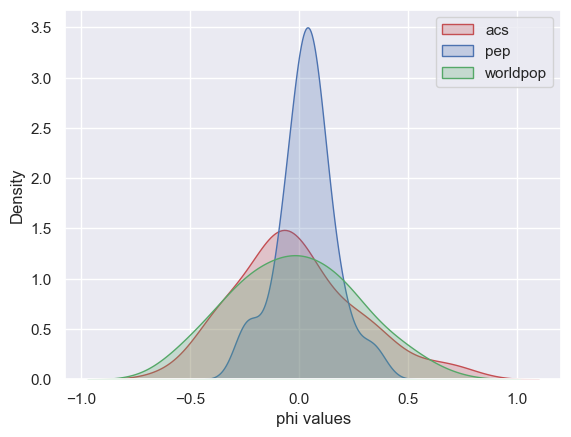

In [20]:
import seaborn as sns

CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

sns.set(style="darkgrid")
fig = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
fig = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
fig = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
plt.legend()
plt.xlabel('phi values')
plt.show()

In [26]:
# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)
exp_phi_rows = tf.reduce_sum(exp_phi, 1)

# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]

In [27]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [28]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [29]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

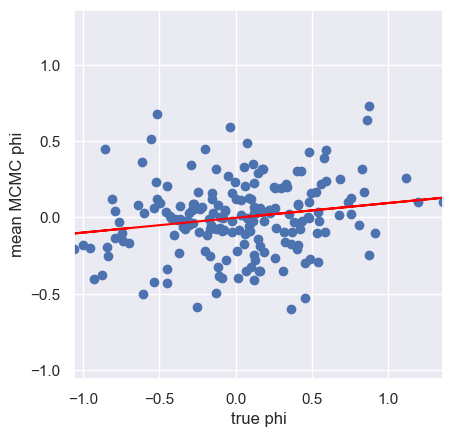

0.18483666371141608

In [30]:
x = np.ndarray.flatten(full_phi.iloc[:,1:].to_numpy())
y = np.ndarray.flatten(CAR_ensemble_weights.numpy())
plt.scatter(x, y)

plt.xlabel("true phi")
plt.ylabel("mean MCMC phi")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]

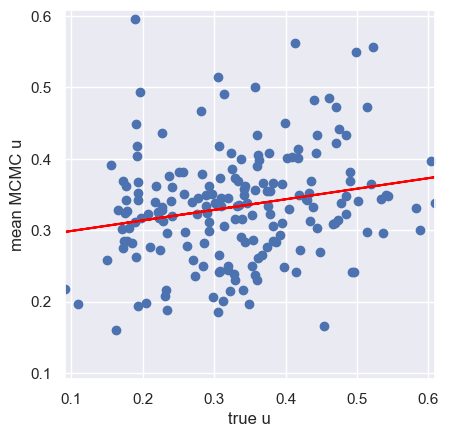

0.20812298960121545

In [31]:
x = np.ndarray.flatten(full_u.iloc[:,1:].values)
y = np.ndarray.flatten(u.numpy())
plt.scatter(x, y)
plt.xlabel("true u")
plt.ylabel("mean MCMC u")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]

In [32]:
y_pred

array([113.95060845947266, 103.07922875976563, 97.51700799560547,
       98.59854196166992, 117.03224992370606, 93.39040296936035,
       99.66695205688477, 99.10255850219727, 98.37144816589355,
       94.95459051513672, 97.785644821167, 108.36525540161132,
       104.83969750976563, 111.60822305297852, 94.43517567443848,
       103.04818717956543, 98.74317945861816, 93.84710975646972,
       111.77672996520997, 102.24429850769043, 89.19313162231445,
       98.4136502380371, 91.69569067382812, 95.62701989746094,
       105.94425305175781, 110.53117794799805, 98.2065146484375,
       104.56585993957519, 117.32785792541505, 101.63905815124512,
       102.0826616821289, 90.3368094329834, 102.34007328796386,
       107.17427294921875, 106.66576402282715, 91.03712600708008,
       104.04694348144531, 90.08505712890624, 106.98848060607911,
       87.10956222534179, 91.02470158386231, 92.0565684967041,
       96.3739766998291, 88.28328526306153, 96.89157475280761,
       103.96222859191894, 9

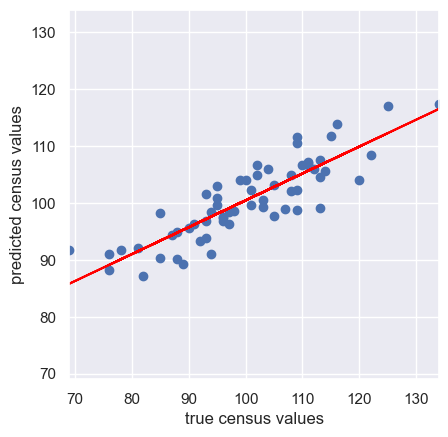

0.8648990988372148

In [33]:
x = data_sub['census']
y = y_pred
#y = y_pred.numpy()
plt.scatter(x, y)
plt.xlabel("true census values")
plt.ylabel("predicted census values")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y.astype('float64'), 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]